In [1]:
from basketball import *

import numpy as np
import pickle
import pandas as pd

## Get Salary Cap info

In [2]:
url = 'https://www.basketball-reference.com/contracts/salary-cap-history.html'

tables = get_tables(url)
df_caps = tables[0]

df_caps.columns = ['Year', 'Salary Cap', 'Salary Cap (2015)']
df_caps.drop(0, inplace=True)
df_caps.reset_index(inplace=True, drop=True)

# Money to float
df_caps['Salary Cap'].replace('\D', '', regex=True, inplace=True)
df_caps['Salary Cap (2015)'].replace('\D', '', regex=True, inplace=True)

df_caps['Salary Cap'] = pd.to_numeric(df_caps['Salary Cap'])
df_caps['Salary Cap (2015)'] = pd.to_numeric(df_caps['Salary Cap (2015)'])

df_caps['Year'] = df_caps['Year'].apply(lambda x: x[:2] + x[-2:])

In [3]:
with open('df_caps.pickle', 'wb') as f:
    pickle.dump(df_caps, f)

In [4]:
df_caps.head()

,Year,Salary Cap,Salary Cap (2015)
0,1985,3600000,7934034.0
1,1986,4233000,9153509.0
2,1987,4945000,10317292.0
3,1988,6164000,12354015.0
4,1989,7232000,13829137.0


## Get Stats

In [5]:
# Advanced tables stored in dictionary. Keys of databases = years.
# values of databases dictionaries are more dictionaries
#     keys = Teams (e.g. MIA, SAS, LAL, ... )

with open('databases.pickle', 'rb') as f:
    databases = pickle.load(f)


yearly_dfs = []

for year in databases.keys():
    adv_stats, adv_sals = database_to_stats_and_salaries(pos=8, year=year, database=databases[year])
    per36_stats, per_sals = database_to_stats_and_salaries(pos=6, year=year, database=databases[year])

    df_adv = stats_salary_join(year=year, dfs=adv_stats, targets=adv_sals)
    df_per_36 = stats_salary_join(year=year, dfs=per36_stats, targets=per_sals)

    # drop duplicate columns
    cols_to_drop = {'Salary', 'MP', 'G', 'Age'}
    cols_to_keep = list(set(df_per_36.columns) - cols_to_drop)
    df_per_36 = df_per_36[cols_to_keep]

    # concat and append the normal stats and advanced stats
    yearly_dfs.append(pd.concat([df_per_36, df_adv], join='inner', axis=1))
        
df_stats = pd.concat(yearly_dfs)
df_stats.head()

Failed to concat DAL
Failed to concat DAL


,,,TRB,3PA,TOV,FTA,Rk,GS,2PA,ORB,3P,AST,...,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP,Salary
Name,Team,Year,,,,,,,,,,,,,,,,,,,,,
Paul Pierce,BOS,2008,5.1,4.6,2.8,6.1,1,80,9.2,0.7,1.8,4.5,...,6.7,5.7,12.4,0.207,NaN,3.3,1.5,4.7,4.9,16360094.0
Ray Allen,BOS,2008,3.7,6.2,1.7,3.3,2,73,7.3,1.0,2.5,3.1,...,5.6,4.1,9.7,0.177,NaN,3.2,-0.1,3.1,3.4,16000000.0
Kevin Garnett,BOS,2008,10.1,0.2,2.1,5.2,3,71,15.1,2.1,0.0,3.8,...,6.6,6.2,12.9,0.265,NaN,2.7,4.7,7.4,5.5,23750000.0
Rajon Rondo,BOS,2008,5.0,0.3,2.3,2.7,4,77,10.8,1.2,0.1,6.1,...,2.3,4.9,7.2,0.150,NaN,-0.1,2.7,2.6,2.7,1229280.0
Kendrick Perkins,BOS,2008,8.9,0.0,2.4,3.4,5,78,6.5,2.7,0.0,1.6,...,1.9,4.3,6.2,0.156,NaN,-1.7,4.3,2.6,2.2,4480912.0


## Joining Stats and Caps

In [19]:
# set index to join (year)
df_caps.set_index('Year', inplace=True)

# Loop through all (player, team, year) combos and get the salary cap for that year

caps = [df_caps.loc[str(ix[2]), 'Salary Cap'] for ix in df_stats.index] 
poc = [df_stats.loc[ix]['Salary'] / df_caps.loc[str(ix[2]), 'Salary Cap'] for ix in df_stats.index]

df_stats['Percentage of Cap'] = poc
df_stats['Caps'] = caps


In [20]:
df_stats.head() # integrated cap info into our dataframe

,,,TRB,3PA,TOV,FTA,Rk,GS,2PA,ORB,3P,AST,...,WS,WS/48,,OBPM,DBPM,BPM,VORP,Salary,Percentage of Cap,Caps
Name,Team,Year,,,,,,,,,,,,,,,,,,,,,
Paul Pierce,BOS,2008,5.1,4.6,2.8,6.1,1,80,9.2,0.7,1.8,4.5,...,12.4,0.207,NaN,3.3,1.5,4.7,4.9,16360094.0,0.294088,55630000
Ray Allen,BOS,2008,3.7,6.2,1.7,3.3,2,73,7.3,1.0,2.5,3.1,...,9.7,0.177,NaN,3.2,-0.1,3.1,3.4,16000000.0,0.287615,55630000
Kevin Garnett,BOS,2008,10.1,0.2,2.1,5.2,3,71,15.1,2.1,0.0,3.8,...,12.9,0.265,NaN,2.7,4.7,7.4,5.5,23750000.0,0.426928,55630000
Rajon Rondo,BOS,2008,5.0,0.3,2.3,2.7,4,77,10.8,1.2,0.1,6.1,...,7.2,0.150,NaN,-0.1,2.7,2.6,2.7,1229280.0,0.022097,55630000
Kendrick Perkins,BOS,2008,8.9,0.0,2.4,3.4,5,78,6.5,2.7,0.0,1.6,...,6.2,0.156,NaN,-1.7,4.3,2.6,2.2,4480912.0,0.080548,55630000


## Feature Engineering

In [150]:
def prepare_dataframe(df, features):
    df = df.copy()
    labels = ['Salary', 'Percentage of Cap', 'Caps']

    # let's drop players with low minutes played per game, say less than 10
    df['MPperG'] = df['MP'] / df['G']
    
    # drop blank columns
    df.drop('\xa0', inplace=True, axis=1)

    # We want over 10 minutes played per game and nonzero salary
    mask = ((df['MPperG'] > 10) & (df['Salary'] > 0) & (df['G'] > 8))
    df = df[mask]

    df = df[features + labels]
    X = df[features].values
    y = df['Percentage of Cap'].values
    
    return X, y, df

## Modelling

In [151]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

### Defining linear model

In [152]:
def run_linear_model(features, scale=False):
    X, y, df = prepare_dataframe(df_stats, features)

    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.2,
                                                       random_state = 1999)

    kf = KFold(n_splits=5, shuffle=True, random_state=1999)

    train_scores = []
    test_scores = []

    for train_index, val_index in kf.split(X_cv):

        X_train, X_val = X_cv[train_index], X_cv[val_index]
        y_train, y_val = y_cv[train_index], y_cv[val_index]
        
        if scale:
            std = StandardScaler()
            X_train = std.fit_transform(X_train)
            X_val = std.transform(X_val)

        lm = LinearRegression()
        lm.fit(X_train, y_train)

        y_train_pred = lm.predict(X_train)
        y_val_pred = lm.predict(X_val)

        train_scores.append(np.round(r2_score(y_train, y_train_pred), 4))
        test_scores.append(np.round(r2_score(y_val, y_val_pred), 4))
        
    lm.fit(X_cv, y_cv)
    
    # pair names of features with their value then sort descending by absolute value
    coefficients = sorted(list(zip(features, np.round(lm.coef_, 4))), key=lambda x: -np.abs(x[1]))
    
    print('Training Scores:\t', train_scores)
    print('Test Scores:\t\t', test_scores)
        
    return train_scores, test_scores, coefficients, df 

### Advanced Features

In [153]:
adv_features = ['Age','PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'WS/48', 'BPM', 'VORP']

train_scores, test_scores, coeffs, df = run_linear_model(adv_features, scale=True)

Training Scores:	 [0.4696, 0.4682, 0.4768, 0.472, 0.4646]
Test Scores:		 [0.4641, 0.4709, 0.4233, 0.4556, 0.4835]


In [154]:
coeffs

[('WS/48', -0.5383),
 ('TS%', -0.4373),
 ('FTr', 0.046),
 ('3PAr', -0.0388),
 ('STL%', -0.032),
 ('TRB%', 0.0298),
 ('ORB%', -0.0206),
 ('DRB%', -0.014),
 ('PER', 0.0137),
 ('BPM', 0.0106),
 ('VORP', 0.009),
 ('BLK%', -0.0075),
 ('Age', 0.0058),
 ('AST%', -0.0023),
 ('TOV%', 0.0021)]

In [155]:
np.mean(test_scores)

0.45948

### Feature Selection with Lasso

In [156]:
df_stats.columns

Index(['TRB', '3PA', 'TOV', 'FTA', 'Rk', 'GS', '2PA', 'ORB', '3P', 'AST',
       'BLK', 'STL', 'FT%', 'DRB', '3P%', 'FGA', 'FG', 'FT', '2P', 'PTS',
       'FG%', '2P%', 'PF', 'Rk', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', ' ',
       'OWS', 'DWS', 'WS', 'WS/48', ' ', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Salary', 'Percentage of Cap', 'Caps'],
      dtype='object', name=0)

In [157]:
features = ['TRB', 'FT', 'FG', 'FTA', 'DRB', 'STL', 'PTS', '3P', '2PA', '2P', 'BLK', '3PA', 'AST', 'FGA', 'FG%', 
       'ORB', 'PF', 'TOV', 'Age', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

X, y, df = prepare_dataframe(df_stats, features)

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.2,
                                                       random_state = 1999)

In [158]:
# examine dataframe for nans

df.isna().sum()

0
TRB                  0
FT                   0
FG                   0
FTA                  0
DRB                  0
STL                  0
PTS                  0
3P                   0
2PA                  0
2P                   0
BLK                  0
3PA                  0
AST                  0
FGA                  0
FG%                  0
ORB                  0
PF                   0
TOV                  0
Age                  0
PER                  0
TS%                  0
3PAr                 0
FTr                  0
ORB%                 0
DRB%                 0
TRB%                 0
AST%                 0
STL%                 0
BLK%                 0
TOV%                 0
USG%                 0
WS/48                0
OBPM                 0
DBPM                 0
BPM                  0
VORP                 0
Salary               0
Percentage of Cap    0
Caps                 0
dtype: int64

In [159]:
from sklearn.model_selection import GridSearchCV

lass_pipe = Pipeline([
    ('std_scl', StandardScaler()),
    ('lass', Lasso())
])

param_grid = {
    'lass__alpha': [.001, .01, .1, 1, 10]
}

gcv = GridSearchCV(lass_pipe, param_grid, cv=5)
gcv.fit(X_cv, y_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std_scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lass', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lass__alpha': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [160]:
coefficients = sorted(list(zip(features, gcv.best_estimator_.named_steps['lass'].coef_)), key=lambda x: -np.abs(x[1]))
coefficients

[('Age', 0.024177192970488308),
 ('VORP', 0.01554016301150673),
 ('BPM', 0.01450515232662941),
 ('PF', -0.011667745575824456),
 ('USG%', 0.011351212654769086),
 ('2PA', 0.010369471107959443),
 ('STL', -0.009535787384513567),
 ('DRB%', 0.008895187376688634),
 ('FTA', 0.008093182204477906),
 ('TS%', -0.004376861451385814),
 ('WS/48', -0.0029221221760041462),
 ('TOV%', 0.0023194491648638117),
 ('ORB', -0.0005976306507693909),
 ('AST', -0.0003255384141105575),
 ('TRB', 0.0),
 ('FT', 0.0),
 ('FG', 0.0),
 ('DRB', 0.0),
 ('PTS', 0.0),
 ('3P', -0.0),
 ('2P', 0.0),
 ('BLK', 0.0),
 ('3PA', -0.0),
 ('FGA', 0.0),
 ('FG%', 0.0),
 ('TOV', 0.0),
 ('PER', -0.0),
 ('3PAr', -0.0),
 ('FTr', 0.0),
 ('ORB%', -0.0),
 ('TRB%', 0.0),
 ('AST%', -0.0),
 ('STL%', -0.0),
 ('BLK%', 0.0),
 ('OBPM', 0.0),
 ('DBPM', 0.0)]

### Last Coefficients left standing

In [203]:
best_tuples = [('Age', 0.024177192970488308),
 ('VORP', 0.01554016301150673),
 ('BPM', 0.01450515232662941),
 ('PF', -0.011667745575824456),
 ('USG%', 0.011351212654769086),
 ('2PA', 0.010369471107959443),
 ('STL', -0.009535787384513567),
 ('DRB%', 0.008895187376688634),
 ('FTA', 0.008093182204477906),
 ('TS%', -0.004376861451385814),
 ('WS/48', -0.0029221221760041462),
 ('TOV%', 0.0023194491648638117),
 ('ORB', -0.0005976306507693909),
 ('AST', -0.0003255384141105575)]


best_coefs = [t[0] for t in best_tuples]
best_coefs

['Age',
 'VORP',
 'BPM',
 'PF',
 'USG%',
 '2PA',
 'STL',
 'DRB%',
 'FTA',
 'TS%',
 'WS/48',
 'TOV%',
 'ORB',
 'AST']

In [204]:
tr_scores, te_scores, coeffs, df_lin = run_linear_model(best_coefs)

Training Scores:	 [0.4765, 0.4731, 0.4799, 0.4753, 0.4696]
Test Scores:		 [0.4612, 0.475, 0.4395, 0.4673, 0.489]


In [205]:
np.mean(te_scores)

0.4664

In [206]:
coeffs

[('TS%', -0.1488),
 ('WS/48', -0.1488),
 ('STL', -0.03),
 ('PF', -0.0116),
 ('BPM', 0.0097),
 ('VORP', 0.0087),
 ('ORB', -0.0071),
 ('FTA', 0.0064),
 ('Age', 0.0059),
 ('2PA', 0.0046),
 ('AST', -0.0036),
 ('USG%', 0.0018),
 ('DRB%', 0.0018),
 ('TOV%', 0.0018)]

### Let's take a look at df_lin

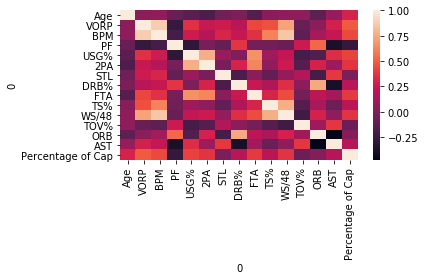

In [237]:
import seaborn as sns

sns.heatmap(df_lin[best_coefs + ['Percentage of Cap']].corr())
plt.tight_layout()
plt.savefig('img/heatmap.png', dpi=300)

In [208]:
df_lin[best_coefs + ['Percentage of Cap']].corr().sort_values('Percentage of Cap', ascending=False)

,Age,VORP,BPM,PF,USG%,2PA,STL,DRB%,FTA,TS%,WS/48,TOV%,ORB,AST,Percentage of Cap
0,,,,,,,,,,,,,,,
Percentage of Cap,0.305124,0.491438,0.438600,-0.269711,0.423243,0.370525,-0.014554,0.195221,0.391986,0.201415,0.369924,-0.068944,0.020537,0.183956,1.000000
VORP,0.042647,1.000000,0.879004,-0.266944,0.365748,0.247559,0.263417,0.196922,0.431745,0.462992,0.727634,-0.078983,0.048870,0.295033,0.491438
BPM,0.060135,0.879004,1.000000,-0.202401,0.263768,0.183655,0.314457,0.239902,0.361868,0.615518,0.850639,-0.114566,0.133272,0.234566,0.438600
USG%,-0.121958,0.365748,0.263768,-0.292253,1.000000,0.764405,0.090170,-0.007653,0.664162,0.111285,0.229390,-0.200938,-0.158130,0.345186,0.423243
FTA,-0.143985,0.431745,0.361868,-0.038844,0.664162,0.626708,0.044216,0.248532,1.000000,0.309668,0.451758,-0.034511,0.216440,0.124024,0.391986
2PA,-0.171097,0.247559,0.183655,-0.026003,0.764405,1.000000,-0.025132,0.308034,0.626708,0.060092,0.259288,-0.142603,0.298418,0.096072,0.370525
WS/48,0.058325,0.727634,0.850639,-0.072529,0.229390,0.259288,0.073020,0.349456,0.451758,0.768794,1.000000,-0.226447,0.301810,0.058496,0.369924
Age,1.000000,0.042647,0.060135,-0.074028,-0.121958,-0.171097,-0.049351,-0.009141,-0.143985,0.028423,0.058325,0.052680,-0.112225,0.079779,0.305124
TS%,0.028423,0.462992,0.615518,-0.043018,0.111285,0.060092,-0.096578,0.168797,0.309668,1.000000,0.768794,-0.144472,0.144459,-0.066574,0.201415


### Running on full data

Let's run the model on the testing set

In [209]:
X, y, df = prepare_dataframe(df_stats, best_coefs)

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.2,
                                                       random_state = 1999)

In [210]:
lm = LinearRegression()
lm.fit(X_cv, y_cv)
y_cv_pred = lm.predict(X_cv)
y_test_pred = lm.predict(X_test)


print('Training Score:\t\t', r2_score(y_cv, y_cv_pred))
print('Testing Score:\t\t', r2_score(y_test, y_test_pred))

Training Score:		 0.47431472633984006
Testing Score:		 0.5276484639337418


It is interesting that this is performing better on the testing set

Let's train the model on all the data

In [211]:
lm.fit(X, y)
y_pred = lm.predict(X)

r2_score(y, y_pred)

0.4879812834154822

In [212]:
df['Predicted Percentage of Cap'] = np.round(y_pred, 4)
df['Predicted Percentage of Cap Error'] = np.round(df['Predicted Percentage of Cap'] - df['Percentage of Cap'], 4)

df['Predicted Salary'] = np.round(df['Predicted Percentage of Cap'] * df['Caps'], -3)
df['Predicted Salary Error'] = np.round(df['Predicted Salary'] - df['Salary'], -3)

In [213]:
df.reset_index(inplace=True)

results = ['Name', 'Team', 'Year', 'Salary', 'Predicted Salary', 'Predicted Salary Error', 'Percentage of Cap', 'Predicted Percentage of Cap', 'Predicted Percentage of Cap Error']

df[results].head()

,Name,Team,Year,Salary,Predicted Salary,Predicted Salary Error,Percentage of Cap,Predicted Percentage of Cap,Predicted Percentage of Cap Error
0,Paul Pierce,BOS,2008,16360094.0,11143000.0,-5217000.0,0.294088,0.2003,-0.0938
1,Ray Allen,BOS,2008,16000000.0,9018000.0,-6982000.0,0.287615,0.1621,-0.1255
2,Kevin Garnett,BOS,2008,23750000.0,14091000.0,-9659000.0,0.426928,0.2533,-0.1736
3,Rajon Rondo,BOS,2008,1229280.0,3749000.0,2520000.0,0.022097,0.0674,0.0453
4,Kendrick Perkins,BOS,2008,4480912.0,4500000.0,19000.0,0.080548,0.0809,0.0004


In [214]:
df[results][df['Year'] == 2014].sort_values('Predicted Percentage of Cap Error').head(15)

,Name,Team,Year,Salary,Predicted Salary,Predicted Salary Error,Percentage of Cap,Predicted Percentage of Cap,Predicted Percentage of Cap Error
2153,Amar'e Stoudemire,NYK,2014,21679893.0,6537000.0,-15143000.0,0.369466,0.1114,-0.2581
2133,Joe Johnson,BRK,2014,21466718.0,8397000.0,-13070000.0,0.365833,0.1431,-0.2227
2135,Deron Williams,BRK,2014,18466130.0,5874000.0,-12592000.0,0.314697,0.1001,-0.2146
2226,Chris Bosh,MIA,2014,19067500.0,7804000.0,-11264000.0,0.324946,0.1330,-0.1919
2192,Derrick Rose,CHI,2014,17632688.0,7347000.0,-10286000.0,0.300494,0.1252,-0.1753
2335,Chris Paul,LAC,2014,18668431.0,8661000.0,-10007000.0,0.318145,0.1476,-0.1705
2432,Eric Gordon,NOP,2014,14283844.0,5105000.0,-9179000.0,0.243423,0.0870,-0.1564
2400,Dwight Howard,HOU,2014,20513178.0,11448000.0,-9065000.0,0.349583,0.1951,-0.1545
2421,Dirk Nowitzki,DAL,2014,22721381.0,13866000.0,-8855000.0,0.387215,0.2363,-0.1509
2147,Carmelo Anthony,NYK,2014,22407474.0,13596000.0,-8811000.0,0.381865,0.2317,-0.1502


In [215]:
### The average error was 60% of the mean salary

df[results].groupby('Name').mean()['Predicted Percentage of Cap Error'].std() / df[results].groupby('Name').mean()['Predicted Percentage of Cap'].mean()

0.568187989664583

## Visualizations

In [216]:
import matplotlib.pyplot as plt

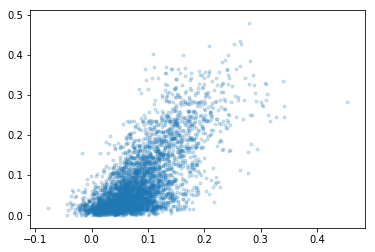

In [217]:
x = df['Predicted Percentage of Cap'].values
y = df['Percentage of Cap'].values

plt.scatter(x, y, alpha=.2, marker='.')

C:\Users\james\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'True Salaries vs Predicted Salaries')

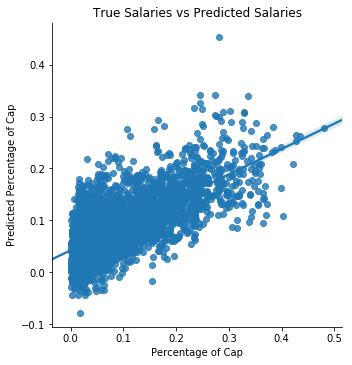

In [218]:
sns.lmplot(x='Percentage of Cap', y='Predicted Percentage of Cap', data=df);
plt.title('True Salaries vs Predicted Salaries')

C:\Users\james\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1080x1440 with 0 Axes>

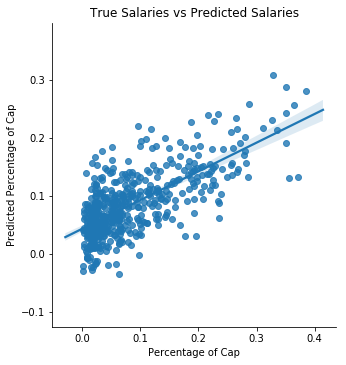

In [238]:
## let's plot fewer points

df_sample = df.sample(500)

plt.figure(figsize=(15, 20))
sns.lmplot(x='Percentage of Cap', y='Predicted Percentage of Cap', data=df_sample);

plt.title('True Salaries vs Predicted Salaries')
plt.axis('equal')
plt.savefig('img/residuals.png', dpi=300)

In [220]:
df[results].sort_values('Predicted Percentage of Cap')

,Name,Team,Year,Salary,Predicted Salary,Predicted Salary Error,Percentage of Cap,Predicted Percentage of Cap,Predicted Percentage of Cap Error
3845,Terrance Ferguson,OKC,2018,1785000.0,-7729000.0,-9514000.0,0.018013,-0.0780,-0.0960
1221,Kevin Seraphin,WAS,2011,1563120.0,-2566000.0,-4129000.0,0.026930,-0.0442,-0.0711
3196,Phil Pressey,PHO,2016,111444.0,-3017000.0,-3128000.0,0.001592,-0.0431,-0.0447
3565,Tyus Jones,MIN,2017,1339680.0,-4020000.0,-5360000.0,0.014230,-0.0427,-0.0569
2061,Kendall Marshall,PHO,2013,1919160.0,-2229000.0,-4148000.0,0.033064,-0.0384,-0.0715
2937,Kelly Oubre,WAS,2016,1920240.0,-2632000.0,-4552000.0,0.027432,-0.0376,-0.0650
2175,Arnett Moultrie,PHI,2014,1089240.0,-2148000.0,-3237000.0,0.018563,-0.0366,-0.0552
2488,Furkan Aldemir,PHI,2015,3000000.0,-2296000.0,-5296000.0,0.047570,-0.0364,-0.0840
3468,Alex Abrines,OKC,2017,5994764.0,-3286000.0,-9281000.0,0.063677,-0.0349,-0.0986
2961,Rashad Vaughn,MIL,2016,1733040.0,-2394000.0,-4127000.0,0.024758,-0.0342,-0.0590


## Some Results

The most overpaid and underpaid players for each year.

In [221]:
def find_over_under(ascending=False):
    players = []

    for year in range(2008, 2019):
        mask = (df['Year'] == year)
        players.append(df[mask].sort_values('Predicted Percentage of Cap Error', ascending=ascending).head(1))

    return pd.concat(players)[results].set_index(['Name', 'Team', 'Year'])

under_df = find_over_under()
over_df = find_over_under(ascending=True)

In [222]:
under_df[['Salary', 'Predicted Salary', 'Predicted Salary Error']].iloc[3:]

0                                   Salary  Predicted Salary  \
Name                  Team Year                                
Shaquille O'Neal      BOS  2011  1352181.0         9554000.0   
Tracy McGrady         ATL  2012  1352181.0         8405000.0   
Tim Duncan            SAS  2013  9638554.0        17077000.0   
DeMarcus Cousins      SAC  2014  4916974.0        12956000.0   
Pau Gasol             CHI  2015  7128000.0        16611000.0   
                           2016  7448760.0        19362000.0   
Giannis Antetokounmpo MIL  2017  2995421.0        20495000.0   
Dwyane Wade           MIA  2018  1471382.0        17827000.0   

0                                Predicted Salary Error  
Name                  Team Year                          
Shaquille O'Neal      BOS  2011               8202000.0  
Tracy McGrady         ATL  2012               7053000.0  
Tim Duncan            SAS  2013               7438000.0  
DeMarcus Cousins      SAC  2014               8039000.0  
Pau Gasol             CHI  2015               9483000.0  
                           2016              11913000.0  
Giannis Antetokounmpo MIL  2017              17500000.0  
Dwyane Wade           MIA  2018              16356000.0

In [223]:
over_df[['Salary', 'Predicted Salary', 'Predicted Salary Error']].iloc[3:]

0                                Salary  Predicted Salary  \
Name              Team Year                                 
Rashard Lewis     WAS  2011  19573711.0         5578000.0   
                       2012  21136631.0         5537000.0   
Amar'e Stoudemire NYK  2013  19948799.0         6814000.0   
                       2014  21679893.0         6537000.0   
                       2015  23410988.0         8337000.0   
Joe Johnson       BRK  2016  24894863.0         9114000.0   
Chandler Parsons  MEM  2017  22116750.0         5922000.0   
Mike Conley       MEM  2018  28530608.0        11148000.0   

0                            Predicted Salary Error  
Name              Team Year                          
Rashard Lewis     WAS  2011             -13996000.0  
                       2012             -15600000.0  
Amar'e Stoudemire NYK  2013             -13135000.0  
                       2014             -15143000.0  
                       2015             -15074000.0  
Joe Johnson       BRK  2016             -15781000.0  
Chandler Parsons  MEM  2017             -16195000.0  
Mike Conley       MEM  2018             -17383000.0

### 

In [231]:
df[df.Name == 'LeBron James'][['Year', 'Salary', 'Predicted Salary', 'Predicted Salary Error']].set_index('Year')

,Salary,Predicted Salary,Predicted Salary Error
Year,,,
2008,13041250.0,17640000.0,4599000.0
2009,14410581.0,20022000.0,5611000.0
2010,15779912.0,19722000.0,3942000.0
2011,14500000.0,16543000.0,2043000.0
2012,16022500.0,17518000.0,1496000.0
2013,17545000.0,18075000.0,530000.0
2014,19067500.0,16941000.0,-2126000.0
2015,20644400.0,17583000.0,-3061000.0
2016,22971000.0,21665000.0,-1306000.0


In [233]:
df[df.Name == 'LeBron James'][['Predicted Salary Error']].mean()

0
Predicted Salary Error    923454.545455
dtype: float64